**M. Teguh Wicaksono**

**Latihan Algoritma Machine Learning**

# Pendahuluan

Nasabah Bank Beta pergi meninggalkan perusahaan: sedikit demi sedikit, jumlah mereka berkurang setiap bulannya. Para pegawai bank menyadari bahwa akan lebih menghemat biaya jika perusahaan fokus untuk mempertahankan nasabah lama mereka yang setia daripada menarik nasabah baru.

Pada kasus ini, tugas kita adalah untuk memprediksi apakah seorang nasabah akan segera meninggalkan bank atau tidak dengan menggunakan 4 algoritma, yaitu :
1. K-Nearest Neighbor
2. Decision Tree Classifier
3. Random Forest Classifier
4. Logistic Regression

Kita akan mencari nilai f1_score tertinggi dari ke-4 algoritma tersebut. Kemudian berikut ini adalah informasi atribut dari data yang kita miliki.


**Informasi Atribut**

| Attribute | Data Type | Description |
| --- | --- | --- |
| RowNumber       | int64   | Indeks string data | 
| CustomerId      | int64   | Nomor ID pelanggan |
| Surname         | object  | Nama belakang |
| CreditScore     | int64   | Skor kredit |
| Geography       | object  | Negara domisili |
| Gender          | object  | Jenis kelamin |
| Age             | int64   | Umur nasabah |
| Tenure          | float64 | Jangka waktu jatuh tempo untuk deposito tetap nasabah (tahun) |
| Balance         | float64 | Saldo rekening |
| NumOfProducts   | int64   | Jumlah produk bank yang digunakan oleh nasabah |
| HasCrCard       | int64   | Apakah nasabah memiliki kartu kredit (1 - jika ya; 0 - jika tidak) |
| IsActiveMember  | int64   | Tingkat keaktifan nasabah (1 - jika ya; 0 - jika tidak) |
| EstimatedSalary | float64 | Estimasi gaji nasabah |
| Exited          | int64   | Apakah nasabah telah berhenti (1 - jika ya; 0 - jika tidak) |


**Target**

`Exited` - `1` Nasabah telah berhenti dan `0` Belum/Tidak

## Import Library

In [3]:
# data manipulation and processing
import pandas as pd
import numpy as np
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# modeling, pre-processing, splitting data, metriks
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
# ignore warning
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

## Memuat dan Pemahaman Tentang Data

In [4]:
# memuat data
df = pd.read_csv('datasets/Churn.csv')

# menampilkan 5 data pertama
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
# informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
# menampilkan ukuran baris dan kolom dataset
df.shape

(10000, 14)

Sepertinya kita mempunyai nilai yang hilang dan nama kolom pada dataset sepertinya juga perlu diganti. Mari kita hitung dan lihat persentase nilai yang hilang pada setiap kolom.

In [7]:
# menghitung jumlah dan persentase nilai yang hilang 
missing_count_report = df.isna().sum().to_frame()
missing_count_report.columns = ['count']
missing_count_report['percent_of_total'] = (missing_count_report['count'] / len(df) * 100).round(2).astype('str')+'%'
# hanya menampilkan tabel dgn nilai yang hilang
missing_count_report.query('count != 0')

,count,percent_of_total
Tenure,909,9.09%


Kita mendapati nilai yang hilang pada kolom `Tenure` sebanyak 909 baris data dan persentasenya sebanyak 9.09%. Selanjutnya kita akan mengganti nama setiap kolom menjadi huruf kecil.

In [8]:
# mengubah nama kolom menjadi huruf kecil
df.columns = df.columns.str.lower()

Selanjutnya kita akan memeriksa duplikat untuk dataset kita, karena kita mempunyai kolom `customerid` sebagai penanda dari setiap customer, kita akan memeriksa duplikat berdasarkan kolom `customerid` tersebut.


In [9]:
# memeriksa duplikat berdasarkan kolom customer id
df.duplicated(subset='customerid').sum()

0

In [10]:
# proses untuk mendapatkan tipe data, jumlah nilai unik, dan value dari nilai unik pada setiap kolom
pd.set_option('display.max_colwidth', 1)

list_data_info = []

# looping untuk mendapatkan informasi
for col in df.columns:
    list_data_info.append([col, df[col].dtypes, df[col].nunique(), df[col].unique()])
    
pd.DataFrame(list_data_info, columns=['columns','data type','number_of_unique','unique_value'])

,columns,data type,number_of_unique,unique_value
0,rownumber,int64,10000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]"
1,customerid,int64,10000,"[15634602, 15647311, 15619304, 15701354, 15737888, 15574012, 15592531, 15656148, 15792365, 15592389, 15767821, 15737173, 15632264, 15691483, 15600882, 15643966, 15737452, 15788218, 15661507, 15568982, 15577657, 15597945, 15699309, 15725737, 15625047, 15738191, 15736816, 15700772, 15728693, 15656300, 15589475, 15706552, 15750181, 15659428, 15732963, 15794171, 15788448, 15729599, 15717426, 15585768, 15619360, 15738148, 15687946, 15755196, 15684171, 15754849, 15602280, 15771573, 15766205, 15771873, 15616550, 15768193, 15683553, 15702298, 15569590, 15760861, 15630053, 15647091, 15623944, 15804771, 15651280, 15773469, 15702014, 15751208, 15592461, 15789484, 15696061, 15641582, 15638424, 15755648, 15703793, 15620344, 15812518, 15779052, 15770811, 15780961, 15614049, 15662085, 15575185, 15803136, 15706021, 15663706, 15641732, 15701164, 15738751, 15805254, 15762418, 15625759, 15622897, 15767954, 15757535, 15731511, 15809248, 15640635, 15676966, 15699461, 15738721, 15693683, 15604348, 15633059, ...]"
2,surname,object,2932,"[Hargrave, Hill, Onio, Boni, Mitchell, Chu, Bartlett, Obinna, He, H?, Bearce, Andrews, Kay, Chin, Scott, Goforth, Romeo, Henderson, Muldrow, Hao, McDonald, Dellucci, Gerasimov, Mosman, Yen, Maclean, Young, Nebechi, McWilliams, Lucciano, Azikiwe, Odinakachukwu, Sanderson, Maggard, Clements, Lombardo, Watson, Lorenzo, Armstrong, Cameron, Hsiao, Clarke, Osborne, Lavine, Bianchi, Tyler, Martin, Okagbue, Yin, Buccho, Chidiebele, Trevisani, O'Brien, Parkhill, Yoo, Phillipps, Tsao, Endrizzi, T'ien, Velazquez, Hunter, Clark, Jeffrey, Pirozzi, Jackson, Hammond, Brownless, Chibugo, Glauert, Pisano, Konovalova, McKee, Palermo, Ballard, Wallace, Cavenagh, Hu, Read, Bushell, Postle, Buley, Leonard, Mills, Onyeorulu, Beit, Ndukaku, Gant, Rowley, Sharpe, Heap, Ritchie, Cole, Capon, Fiorentini, Graham, Yuille, Allard, Fanucci, Fu, Hung, ...]"
3,creditscore,int64,460,"[619, 608, 502, 699, 850, 645, 822, 376, 501, 684, 528, 497, 476, 549, 635, 616, 653, 587, 726, 732, 636, 510, 669, 846, 577, 756, 571, 574, 411, 591, 533, 553, 520, 722, 475, 490, 804, 582, 472, 465, 556, 834, 660, 776, 829, 637, 550, 698, 585, 788, 655, 601, 656, 725, 511, 614, 742, 687, 555, 603, 751, 581, 735, 661, 675, 738, 813, 657, 604, 519, 664, 678, 757, 416, 665, 777, 543, 506, 493, 652, 750, 729, 646, 647, 808, 524, 769, 730, 515, 773, 814, 710, 413, 623, 670, 622, 785, 605, 479, 685, ...]"
4,geography,object,3,"[France, Spain, Germany]"
5,gender,object,2,"[Female, Male]"
6,age,int64,70,"[42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38, 46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30, 28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68, 23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81, 92, 83]"
7,tenure,float64,11,"[2.0, 1.0, 8.0, 7.0, 4.0, 6.0, 3.0, 10.0, 5.0, 9.0, 0.0, nan]"
8,balance,float64,6382,"[0.0, 83807.86, 159660.8, 125510.82, 113755.78, 115046.74, 142051.07, 134603.88, 102016.72, 143129.41, 132602.88, 136815.64, 141349.43, 59697.17, 85311.7, 110112.54, 134264.04, 145260.23, 76548.6, 70349.48, 122522.32, 117419.35, 131394.56, 155931.11, 109421.13, 112045.67, 137843.8, 103391.38, 103769.22, 116363.37, 146050.97, 125561.97, 98495.72, 125211.92, 127864.4, 75888.2, 40685.92, 136857.0, 152328.88, 56084.69, 78707.16, 109166.37, 169831.46, 101633.04, 123180.01, 150725.53, 98373.26, 133745.44, 163607.18, 157780.84, 178718.19, 77253.22, 122189.66, 96645.54, 90307.62, 121681.82, 81623.67, 118626.55, 

**Kesimpulan**

1. Dataset terdiri atas `10.000` baris dan `14` kolom dan juga terdapat missing value hanya pada satu kolom yaitu `tenure` dengan persentasenya 9.09% .
2. Untuk tipe data mungkin kita akan mengubah 1 kolom menjadi `integer` sedangkan pada kolom lain tipe datanya sudah sesuai dan saat pengecekan duplikat berdasarkan `customerid`, dapat dilihat bahwa dataset kita tidak memiliki duplikat.
3. Kolom yang akan menjadi target pada proses machine learning nanti adalah kolom `excited` sedangkan sisanya akan kita jadikan fitur. Akan tetapi, untuk fitur kolom kita akan membuang beberapa kolom karena dianggap tidak penting dalam pelatihan model. Nama-nama kolom yang akan dibuang yaitu:
    * `rownumber`
    * `customerid`
    * `surname`
4. Dari keseluruhan dataset yang akan kita pakai untuk pelatihan machine learning jenis datanya sebagian besar itu numerikal dan juga terdapat beberapa kolom fitur yang merupakan variabel kategorik nominal.

## Pembersihan dan Memperkaya Kualitas Data

Pada tahap sebelumnya kita berpendapat akan menghapus tiga kolom fitur yang dianggap tidak penting. Namun untuk kali ini kita akan menyisakan kolom `customerid` sebagai penanda dari setiap nasabah yang akan digunakan pada tahap analisis data eksploratif (EDA), sedangkan untuk 2 kolom lainnya akan kita hapus dan kita akan menambahkan beberapa kolom baru untuk mengelompokkan usia ataupun kelompok gaji setiap nasabah dalam rentang tertentu.

In [11]:
# menghapus kolom rownumber dan surname
df = df.drop(['rownumber','surname'], axis=1)

### Mengatasi Nilai Yang Hilang Pada Kolom `tenure`.



In [12]:
# melihat distribusi data pada kolom tenure serta menampilkan jumlah nilai yang hilang
df.tenure.value_counts(dropna=False)

tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

Sebelum mengatasi nilai yang hilang pada kolom `tenure` kita akan mengelompokkan usia dan gaji nasabah dalam rentang tertentu, hal ini bertujuan agar kita bisa mencari pola serta dapat mengambil keputusan untuk mengisi nilai yang hilang tersebut.

In [13]:
# membuat fungsi untuk mengelompokkan usia dalam rentang 10 tahun
def age_grouped(age):
    if age <= 10:
        return '0-10'
    elif age <= 20:
        return '11-20'
    elif age <= 30:
        return '21-30'
    elif age <= 40:
        return '31-40'
    elif age <= 50:
        return '41-50'
    elif age <= 60:
        return '51-60'
    elif age <= 70:
        return '61-70'
    else:
        return '70+'

In [14]:
# menerapkan fungsi dan menambahkan kolom baru dgn nama 'age_grouped'
df.insert(5, 'age_grouped', df['age'].apply(age_grouped))  

In [15]:
# membuat tabel dengan kelompok usia untuk melihat pola nilai yang hilang
age_grouped_df = df.query('tenure.isna()').groupby('age_grouped')['age_grouped'].count().to_frame()
age_grouped_df.columns = ['tenure_missing']
age_grouped_df.insert(1, 'tenure_not_missing', df.query('tenure.notna()').groupby('age_grouped')['age_grouped'].count().to_frame())
age_grouped_df

,tenure_missing,tenure_not_missing
age_grouped,,
11-20,6,83
21-30,159,1720
31-40,442,4009
41-50,197,2123
51-60,74,723
61-70,22,309
70+,9,124


Sepertinya nilai yang hilang berdasarkan kelompok usia terjadi secara acak, dapat dilihat bahwa terdapat nilai yang hilang pada setiap kelompok usia.

**Mencari pola berdasarkan negara asal nasabah**

In [16]:
# membuat tabel dengan kelompok negara asal nasabah untuk melihat pola nilai yang hilang
country_df = df.query('tenure.isna()').groupby('geography')['geography'].count().to_frame()
country_df.columns = ['tenure_missing']
country_df.insert(1, 'tenure_not_missing',df.query('tenure.notna()').groupby('geography')['geography'].count().to_frame())
country_df

,tenure_missing,tenure_not_missing
geography,,
France,464,4550
Germany,216,2293
Spain,229,2248


Sepertinya berdasarkan negara asal nasabah juga tidak ditemukan pola untuk nilai yang hilang, hal ini terjadi secara acak. Kita akan coba mengelompokkan gaji nasabah dan mencari polanya.

**Mencari pola berdasarkan kelompok gaji**

In [17]:
# menampilkan minimum gaji nasabah disebelah kiri dan maksimum gaji nasabah disebelah kanan
df.estimatedsalary.min(), df.estimatedsalary.max()

(11.58, 199992.48)

Karena perkiraan gaji nasabah berkisar dari 11 hingga hampir 200.000 dollar, maka kita akan mengelompokkan gaji nasabah dalam rentang 40.000 dollar saja.

In [18]:
# membuat fungsi untuk mengelompokkan gaji nasabah
def salary_grouped(salary):
    if salary <= 40000:
        return '0 - 40.000'
    elif salary <= 80000:
        return '40.001 - 80.000'
    elif salary <= 120000:
        return '80.001 - 120.000'
    elif salary <= 160000:
        return '120.001 - 160.000'
    else:
        return '160.001 - 200.000'

In [19]:
# menerapkan fungsi dan membuat kolom baru dgn nama salary_grouped
df['salary_grouped'] = df['estimatedsalary'].apply(salary_grouped)

In [20]:
# membuat tabel utk nilai yang hilang berdasarkan salary_grouped
salary_grouped_df = df.query('tenure.isna()').groupby('salary_grouped')['salary_grouped'].count().to_frame()
salary_grouped_df.columns = ['tenure_missing']
salary_grouped_df.insert(1, 'tenure_not_missing', df.query('tenure.notna()').groupby('salary_grouped')['salary_grouped'].count().to_frame())
salary_grouped_df

,tenure_missing,tenure_not_missing
salary_grouped,,
0 - 40.000,168,1787
120.001 - 160.000,186,1803
160.001 - 200.000,168,1826
40.001 - 80.000,204,1829
80.001 - 120.000,183,1846


Sepertinya juga tidak terlihat sebuah pola, mari kita kelompok berdasarkan ketiga aturan diatas sekaligus.

In [21]:
# menghitung nilai yang hilang berdasarkan rentang gaji, umur, dan negara asal nasabah
tenure_count_pivot = df.query('tenure.isna()').pivot_table(index=['geography','salary_grouped'],
                                                           columns='age_grouped', values='customerid',
                                                           aggfunc='count'
                                                          )
# tabel yang dihasilkan adalah jumlah nilai yg hilang berdasarkan negara asal, rentang gaji, dan rentang usia. 
# angka didalam tabel menunjukkan jumlah data dgn nilai yang hilang pada suatu kategori
tenure_count_pivot.fillna(0).astype('int')

age_grouped                  11-20  21-30  31-40  41-50  51-60  61-70  70+
geography salary_grouped                                                  
France    0 - 40.000         1      12     51     16     8      3      0  
          120.001 - 160.000  0      23     44     13     9      2      0  
          160.001 - 200.000  0      17     44     11     8      2      2  
          40.001 - 80.000    1      18     57     30     3      1      0  
          80.001 - 120.000   0      12     45     22     6      1      2  
Germany   0 - 40.000         0      9      13     14     5      3      0  
          120.001 - 160.000  0      8      22     11     3      1      0  
          160.001 - 200.000  0      5      27     9      4      0      0  
          40.001 - 80.000    0      9      22     9      5      0      0  
          80.001 - 120.000   0      6      16     6      7      1      1  
Spain     0 - 40.000         0      8      9      13     0      3      0  
          120.001 - 160.000  1      9      24     10     3      1      2  
          160.001 - 200.000  0      7      14     12     3      2      1  
          40.001 - 80.000    1      9      24     9      6      0      0  
          80.001 - 120.000   2      7      30     12     4      2      1

Sepertinya polanya memang acak, untuk itu kita akan mengisinya dengan nilai median berdasarkan negara asal, kelompok gaji, dan kelompok usia agar kita bisa mendapatkan hasil yang lebih akurat.

In [22]:
# menghitung median berdasarkan rentang gaji, umur, dan negara asal nasabah
tenure_median_count_pivot = df.query('tenure.notna()').pivot_table(index=['geography','salary_grouped'],
                                                           columns='age_grouped', values='tenure',
                                                           aggfunc='median'
                                                          )
# tabel yang dihasilkan nilai median berdasarkan negara asal, rentang gaji, dan rentang usia
tenure_median_count_pivot

age_grouped                  11-20  21-30  31-40  41-50  51-60  61-70  70+
geography salary_grouped                                                  
France    0 - 40.000         6.5    5.0    6.0    5.0    5.0    5.0    3.5
          120.001 - 160.000  3.5    5.0    5.0    5.0    5.0    5.5    5.0
          160.001 - 200.000  7.0    5.0    5.0    5.0    6.0    5.0    5.0
          40.001 - 80.000    4.5    5.0    5.0    5.0    5.0    5.0    5.0
          80.001 - 120.000   2.0    5.0    5.0    5.0    5.0    4.0    6.5
Germany   0 - 40.000         6.5    4.0    5.0    4.0    4.0    5.0    5.0
          120.001 - 160.000  2.5    5.0    5.0    5.0    7.0    3.0    4.0
          160.001 - 200.000  3.0    4.0    5.0    5.0    5.5    7.0    6.0
          40.001 - 80.000    0.0    5.0    5.0    5.0    5.0    5.0    7.0
          80.001 - 120.000   5.0    5.0    5.0    4.0    3.0    3.0    5.0
Spain     0 - 40.000         7.0    4.0    5.0    4.0    3.0    5.0    8.0
          120.001 - 160.000  5.0    6.0    5.0    5.0    5.0    5.0    5.0
          160.001 - 200.000  6.5    6.0    5.0    5.0    5.5    3.5    4.0
          40.001 - 80.000    6.0    5.0    5.0    6.0    4.0    3.5    5.0
          80.001 - 120.000   8.0    5.5    5.0    5.0    5.5    4.0    7.0

Kita akan mengisi nilai yang hilang berdasarkan tabel median diatas, untuk itu kita lanjut dengan membuat fungsinya.

In [23]:
# membuat fungsi untuk mengisi nilai yang hilang
def fill_in_tenure(data):
    age_grouped = data['age_grouped']
    salary_grouped = data['salary_grouped']
    country = data['geography']
    # mengembalikan nilai dari pivot tabel yang kita hitung mediannya
    return tenure_median_count_pivot[age_grouped][country, salary_grouped]

In [24]:
# menerapkan fungsi dan mengisi nilai yang hilang
df['tenure'] = np.floor(df['tenure'].fillna(df.apply(fill_in_tenure, axis=1)))

In [25]:
# mengecek kembali nilai yang hilang dan distribusi seluruh data pada kolom tenure
df.tenure.value_counts(dropna=False)

tenure
5.0     1660
6.0     969 
4.0     956 
1.0     952 
2.0     950 
3.0     939 
8.0     935 
7.0     929 
9.0     882 
10.0    446 
0.0     382 
Name: count, dtype: int64

Oke, pada tahap ini kita sudah selesai dan sudah mengatasi nilai yang hilang, selanjutnya kita akan masuk ke tahap analisis data eksploratif (EDA).

## Analisis Data Eksploratif (EDA)

Pada tahap ini kita akan mencari tahu bagaimana jumlah nasabah berdasarkan negara, jenis kelamin, kelompok usia, pendapatan terdistribusi. Kita juga akan mencari tahu negara mana dengan nasabah terbanyak, gaji terendah dan tertinggi serta jumlah produk terbanyak yang digunakan oleh nasabah. Mungkin akan ada tambahan tahapan lainnya yang akan dikerjakan pada tahap ini, untuk itu kita akan coba melakukan tahapan-tahapan yang telah disebutkan diatas.

In [26]:
# membuat fungsi untuk annotate bar supaya membantu dalam visualisasi
def annotate_bar(data, num_bar):
    for bar in data.patches:
        if num_bar == 'int':
            data.annotate(format(bar.get_height().astype('int')),
                          (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                          ha = 'center', va = 'center', size = 10,
                          xytext = (0, 25),
                          textcoords = 'offset points', 
                          rotation = 60)
        else:
            data.annotate(format(bar.get_height(), '.2f'),
                          (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                          ha = 'center', va = 'center',
                          size = 10,
                          xytext = (0, 25),
                          textcoords = 'offset points',
                          rotation = 60)
# warna untuk plot
color_plot = ['#de972c','#74c91e','#1681de','#e069f5','#f54545','#f0ea46','#7950cc']

### Analisis Kolom Kategorik

In [27]:
# variabel yg menyimpan kolom kategorik
categoric_cols = df.describe(include='object').columns

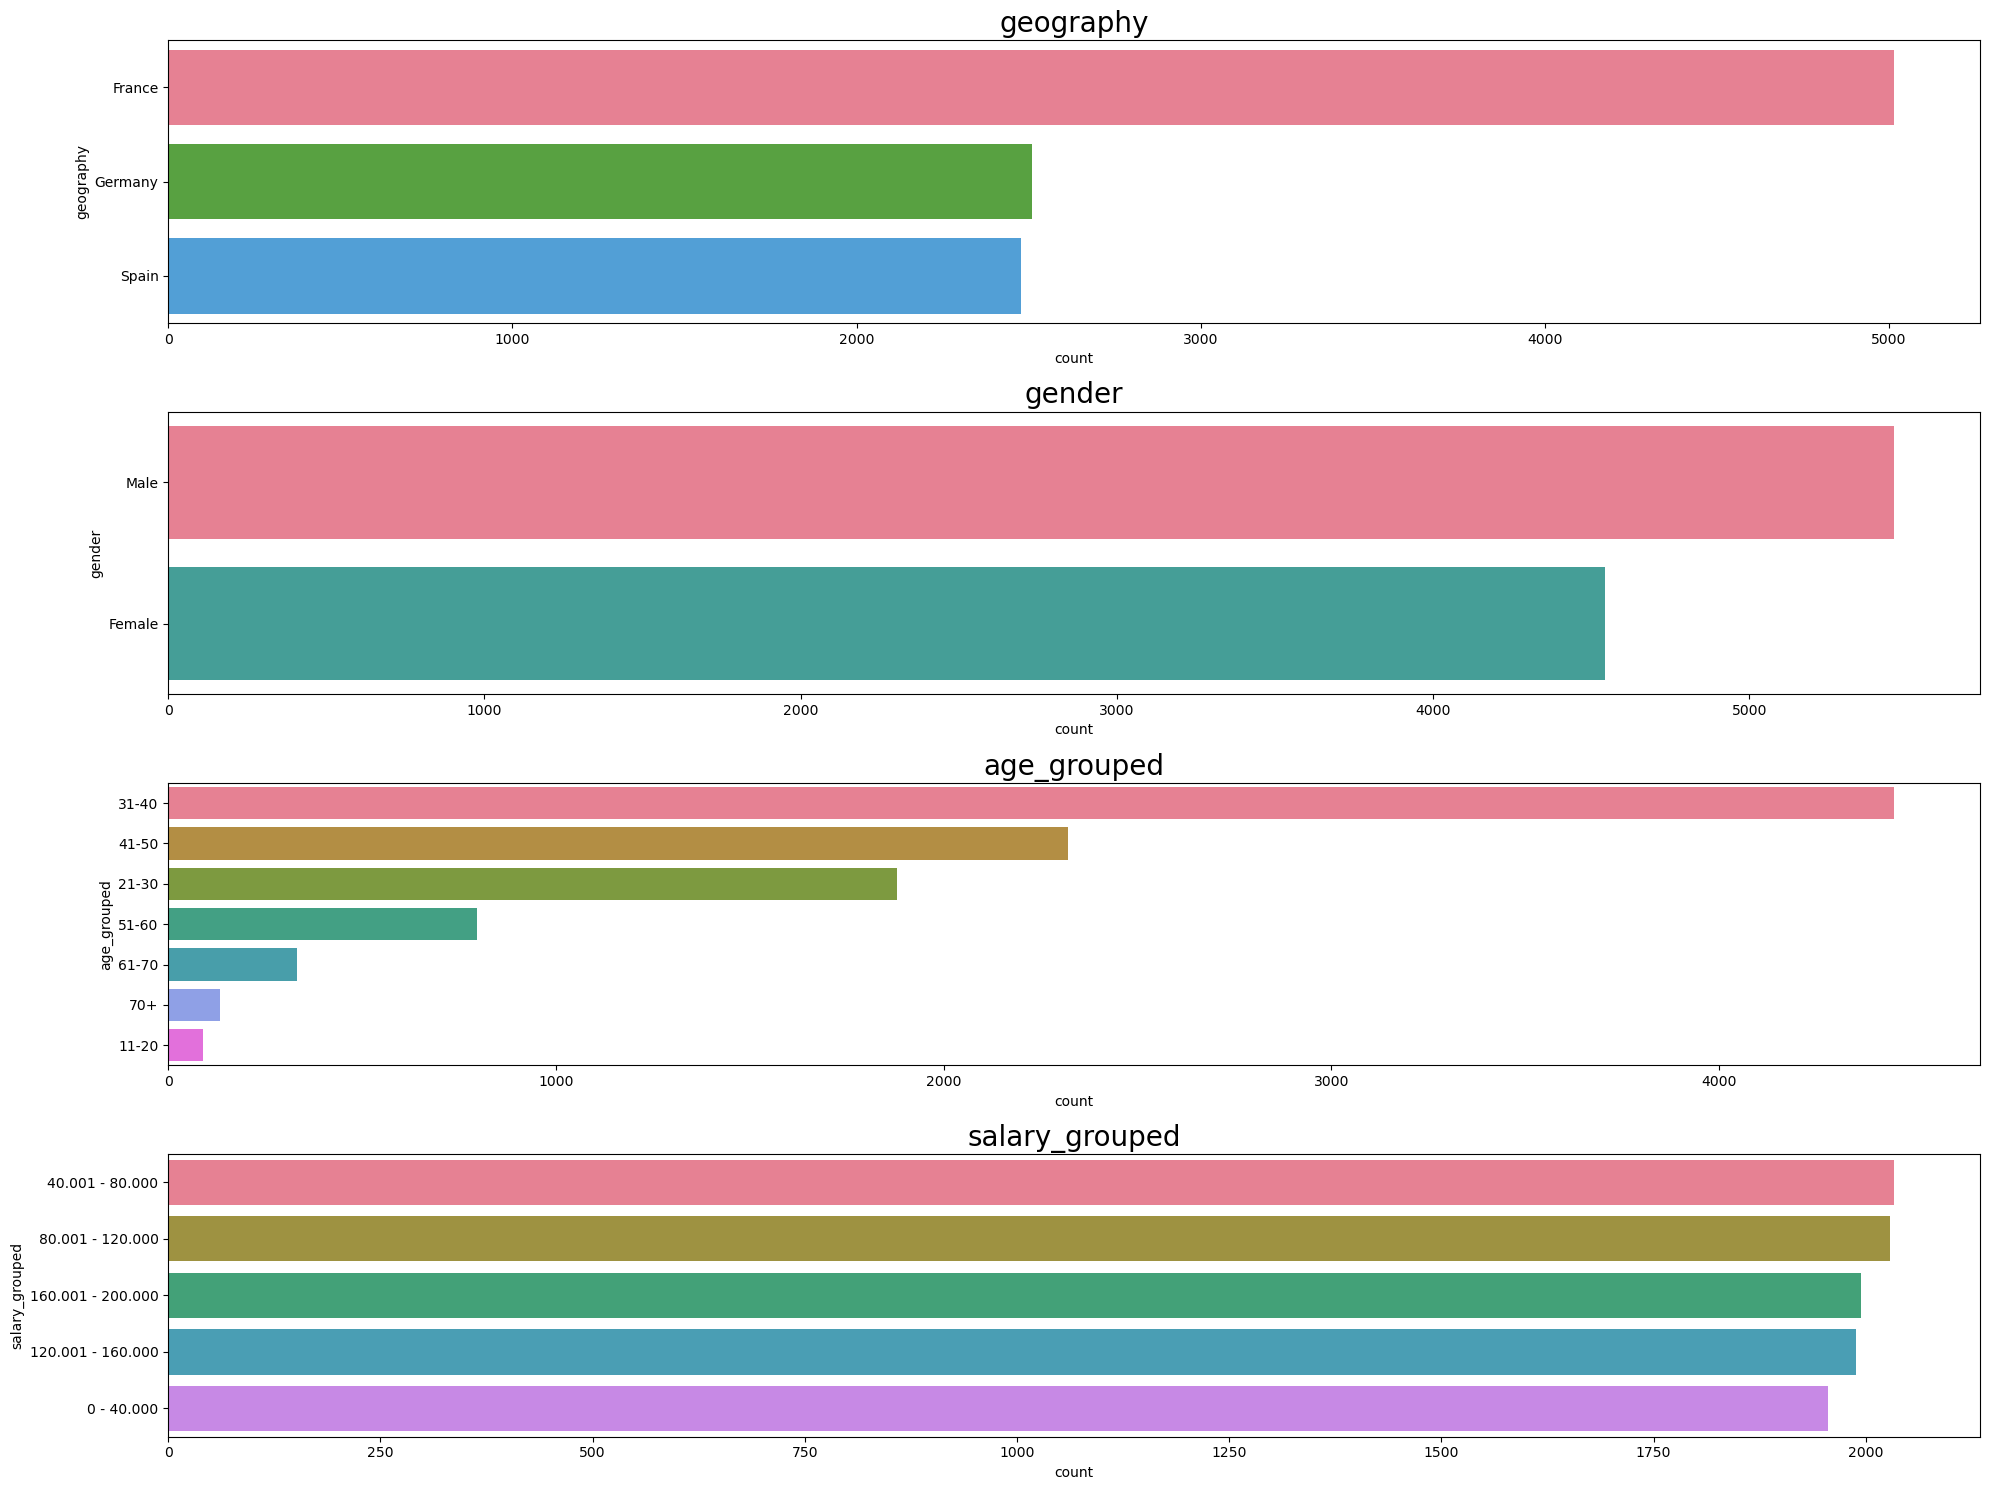

In [28]:
# menampilkan distribusi data pada kolom kategorikal
fig, axes = plt.subplots(4, 1, figsize=(20, 15)) 
for i, j in zip(categoric_cols, axes.flatten()):
    ax = sns.countplot(data=df, y= i, ax= j, order=df[i].value_counts().index, palette='husl')
    ax.set_title(f'{i}',size = 20) 
plt.tight_layout()
plt.show()

**Kesimpulan**

1. Jumlah nasabah paling banyak berasal dari negara Prancis dengan totalnya 5.000 nasabah sedangkan untuk negara Jerman dan Spanyol berjumlah setengah dari nasabah negara Prancis. 
2. Nasabah pada umunya berusia 31-40 tahun dimana ini termasuk usia produktifnya manusia.
3. Untuk nasabah yang berjenis kelamin laki-laki dan perempuan perbedaannya tidak terlalu jauh.

#### Mengamati Perilaku Nasabah Yang Meninggalkan Bank

Tahapan ini kita akan mengamati perilaku nasabah yang telah meninggalkan bank.

In [29]:
# memfilter nasabah yang meninggalkan bank untuk dianalisis
ex_cust = df.query('exited == 1')

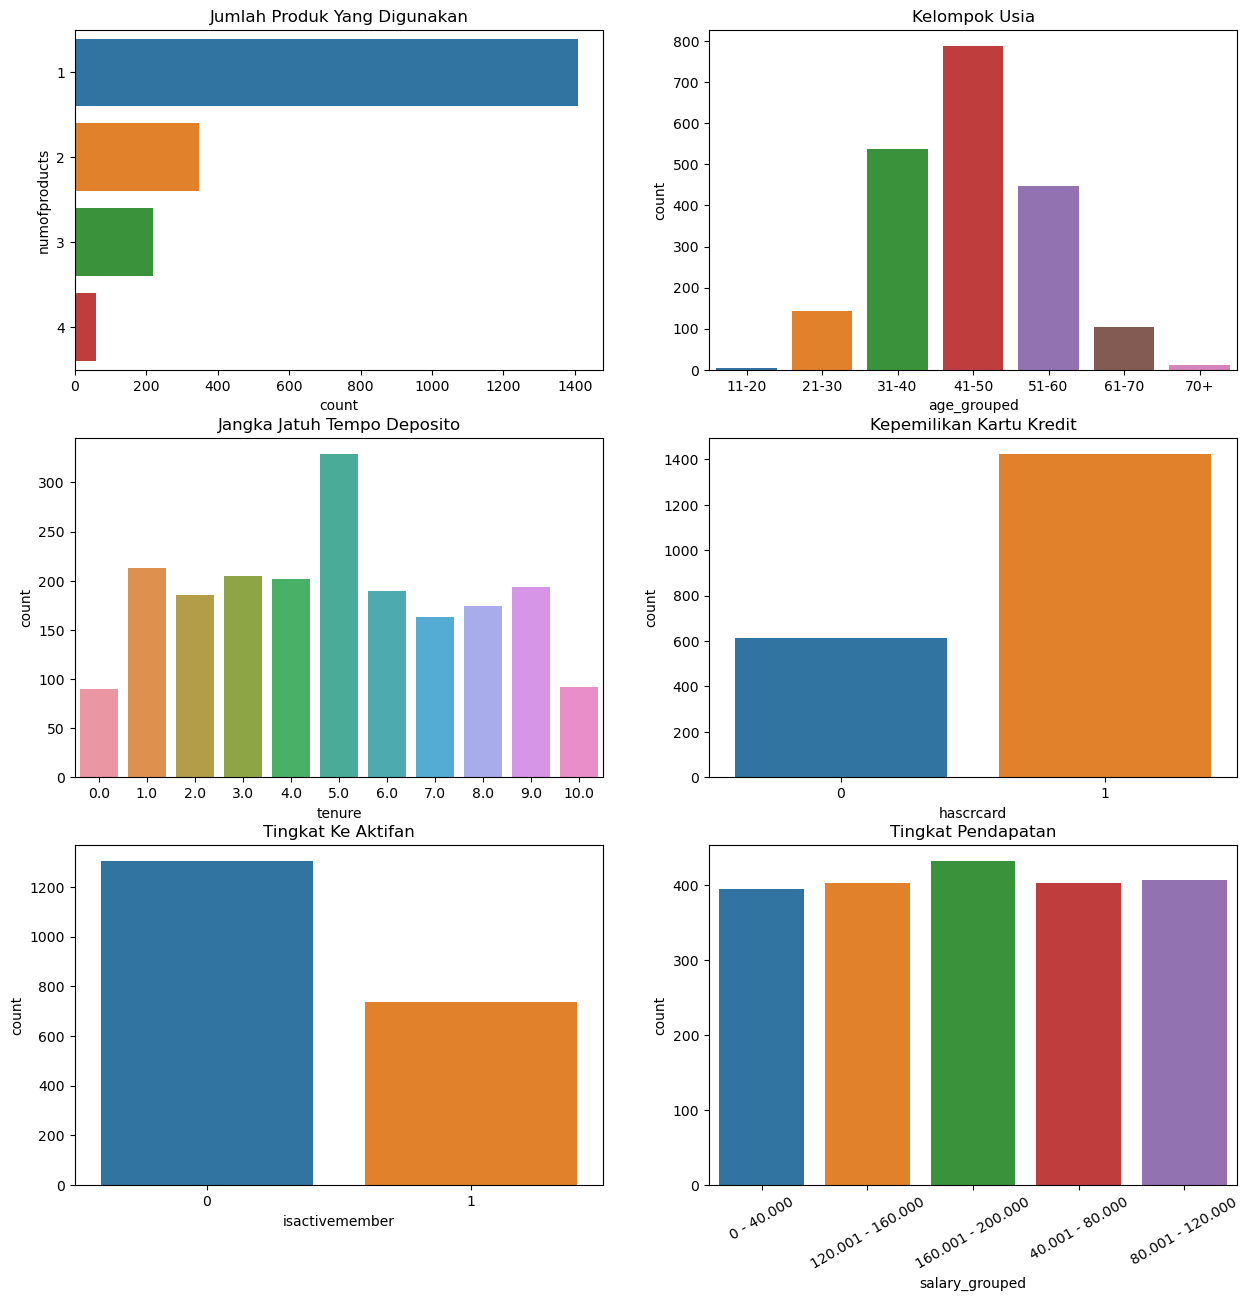

In [30]:
# plot perilaku nasabah yang meninggalkan bank
fig, axes = plt.subplots(3, 2, figsize=(15,15))

sns.countplot(data=ex_cust, y = 'numofproducts', ax = axes[0,0]).set_title('Jumlah Produk Yang Digunakan')
sns.countplot(data=ex_cust.sort_values('age_grouped'), x='age_grouped', ax = axes[0,1]).set_title('Kelompok Usia')
sns.countplot(data=ex_cust, x='tenure', ax = axes[1,0]).set_title('Jangka Jatuh Tempo Deposito')
sns.countplot(data=ex_cust, x='hascrcard', ax = axes[1,1]).set_title('Kepemilikan Kartu Kredit')
sns.countplot(data=ex_cust, x='isactivemember', ax = axes[2,0]).set_title('Tingkat Ke Aktifan')
sns.countplot(data=ex_cust.sort_values('salary_grouped'), x='salary_grouped', ax = axes[2,1]).set_title('Tingkat Pendapatan')
axes[2,1].set_xticklabels(axes[2,1].get_xticklabels(), rotation=30)
plt.show()

**Kesimpulan**

1. Nasabah yang meninggalkan bank mayoritas hanya menggunakan 1 produk yang diberikan oleh layanan bank.
2. Nasabah yang meninggalkan bank terbanyak berusia diantara 41-50 tahun dan sepertinya dari keseluruhan nasabah yang berusia 51-60 tahun 50 persennya telah berhenti menggunakan layanan bank.
3. Jangka jatuh tempo untuk deposito yang diambil nasabah sepertinya tidak memberikan alasan khusus penyebab nasabah itu berhenti, sama halnya seperti tingkat pendapatan nasabah.
4. Proporsi nasabah yang tidak aktif sekitar 60% dibandingkan dgn nasabah yang aktif hanya sekitar 40% dan untuk kepemilikan kartu kredit sepertinya mayoritas nasabah memiliki kartu kredit.

#### Mengamati Perbandingan Antara ke-2 Kategori Nasabah.

Kita akan mencoba mengamati perbandingan dengan jumlah penggunaan produk, kelompok usia, tingkat keaktifan, tenure (waktu jatuh tempo deposito) nasabah dari ke-2 kategori nasabah yang ada.

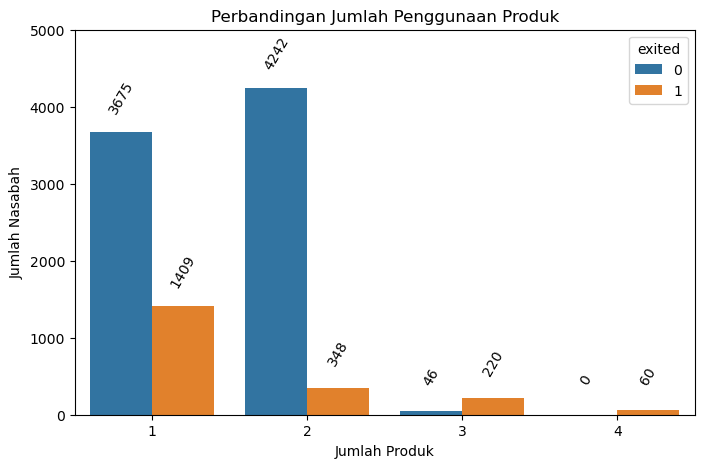

In [31]:
## memplotkan perbandingan jumlah penggunaan product
plt.figure(figsize=(8,5))

product_compare_plot = sns.countplot(data=df, x='numofproducts', hue='exited')

annotate_bar(product_compare_plot, 'int')

plt.ylim(0, 5000)
plt.title('Perbandingan Jumlah Penggunaan Produk')
plt.xlabel('Jumlah Produk')
plt.ylabel('Jumlah Nasabah')
plt.show()

Sepertinya dari keseluruhan nasabah memang menggunakan 1 atau 2 produk dari layanan yang disediakan oleh bank. Namun pada penggunaan 3 dan 4 jumlah produk dapat dilihat bahwa nasabah yang tidak meninggalkan bank jumlahnya sedikit bahkan hampir tidak ada dari pada nasabah yang meninggalkan bank.

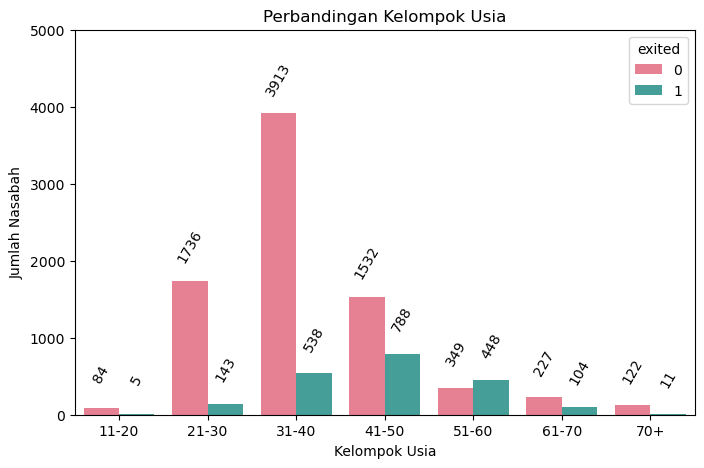

In [32]:
## memplotkan perbandingan kelompok usia nasabah
plt.figure(figsize=(8,5))

age_grouped_compare_plot = sns.countplot(data=df.sort_values('age_grouped'), 
                                         x='age_grouped', 
                                         palette= 'husl',
                                         hue='exited')

annotate_bar(age_grouped_compare_plot, 'int')

plt.ylim(0, 5000)
plt.title('Perbandingan Kelompok Usia')
plt.xlabel('Kelompok Usia')
plt.ylabel('Jumlah Nasabah')
plt.show()

Untuk kategori usia dari 21 hingga 40 tahun persentase nasabah yang meninggalkan bank bisa dibilang cukup kecil dibandingkan yang lainnya.

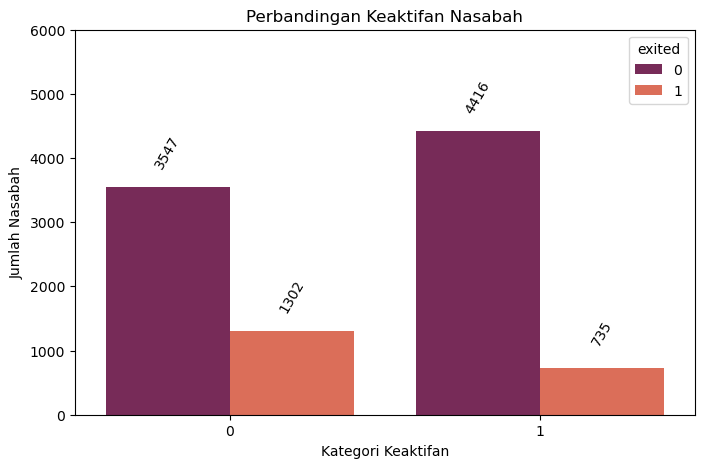

In [33]:
## memplotkan perbandingan keaktifan nasabah
plt.figure(figsize=(8,5))

isactive_compare_plot = sns.countplot(data=df, x='isactivemember', hue='exited', palette='rocket')

annotate_bar(isactive_compare_plot, 'int')

plt.ylim(0, 6000)
plt.title('Perbandingan Keaktifan Nasabah')
plt.xlabel('Kategori Keaktifan')
plt.ylabel('Jumlah Nasabah')
plt.show()

Untuk nasabah yang tidak meninggalkan layanan bank dapat dilihat perbedaan bahwa nasabah yang aktif lebih banyak dari pada yang tidak aktif, sedangkan yang meninggalkan bank lebih banyak nasabah yang tidak aktif. Untuk itu mungkin akan jika lebih baik agar nasabah didorong keaktifannya untuk meminimalisir kepergian nasabah.

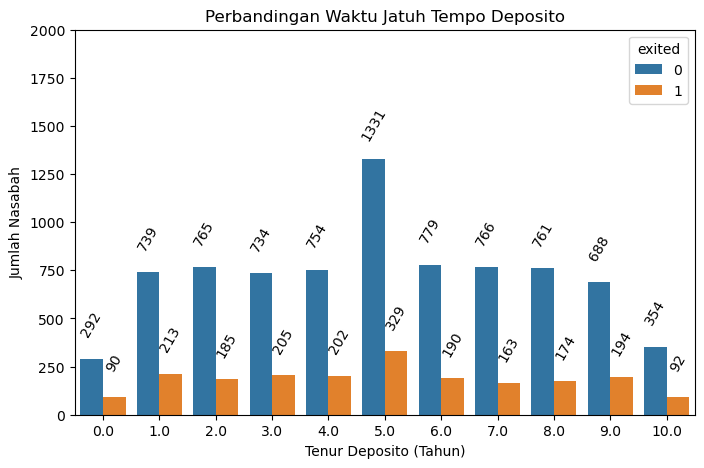

In [34]:
## memplotkan perbandingan kelompok usia nasabah
plt.figure(figsize=(8,5))

tenure_compare_plot = sns.countplot(data=df, x='tenure', hue='exited')

annotate_bar(tenure_compare_plot, 'int')

plt.ylim(0, 2000)
plt.title('Perbandingan Waktu Jatuh Tempo Deposito')
plt.xlabel('Tenur Deposito (Tahun)')
plt.ylabel('Jumlah Nasabah')
plt.show()

dari sini dapat dilihat bahwa nasabah yang meninggalkan bank dapat terjadi disetiap tenur deposito yang diambil/digunakan.

**Kesimpulan**

Berdasarkan analisis perbandingan diantara ke-2 kategori nasabah mungkin akan lebih baik jika bank mencoba meningkatkan jumlah nasabah di kategori umur 21-40 tahun, kemudian berikan tawaran-tawaran yang menarik keaktifan nasabah sehingga nasabah dapat menggunakan setidaknya 2 produk layanan yang diberikan oleh bank, mungkin hal ini dapat meminimalisir tingkat persentase nasabah yang meninggalkan bank. 

### Analisis Kolom Numerik

In [35]:
# variabel menyimpan numerik kolom tanpa `customerid`,`hascrcard`,`isactivemember`,'exited'
numeric_cols = df.describe().columns.drop(['customerid','hascrcard','isactivemember','exited'])

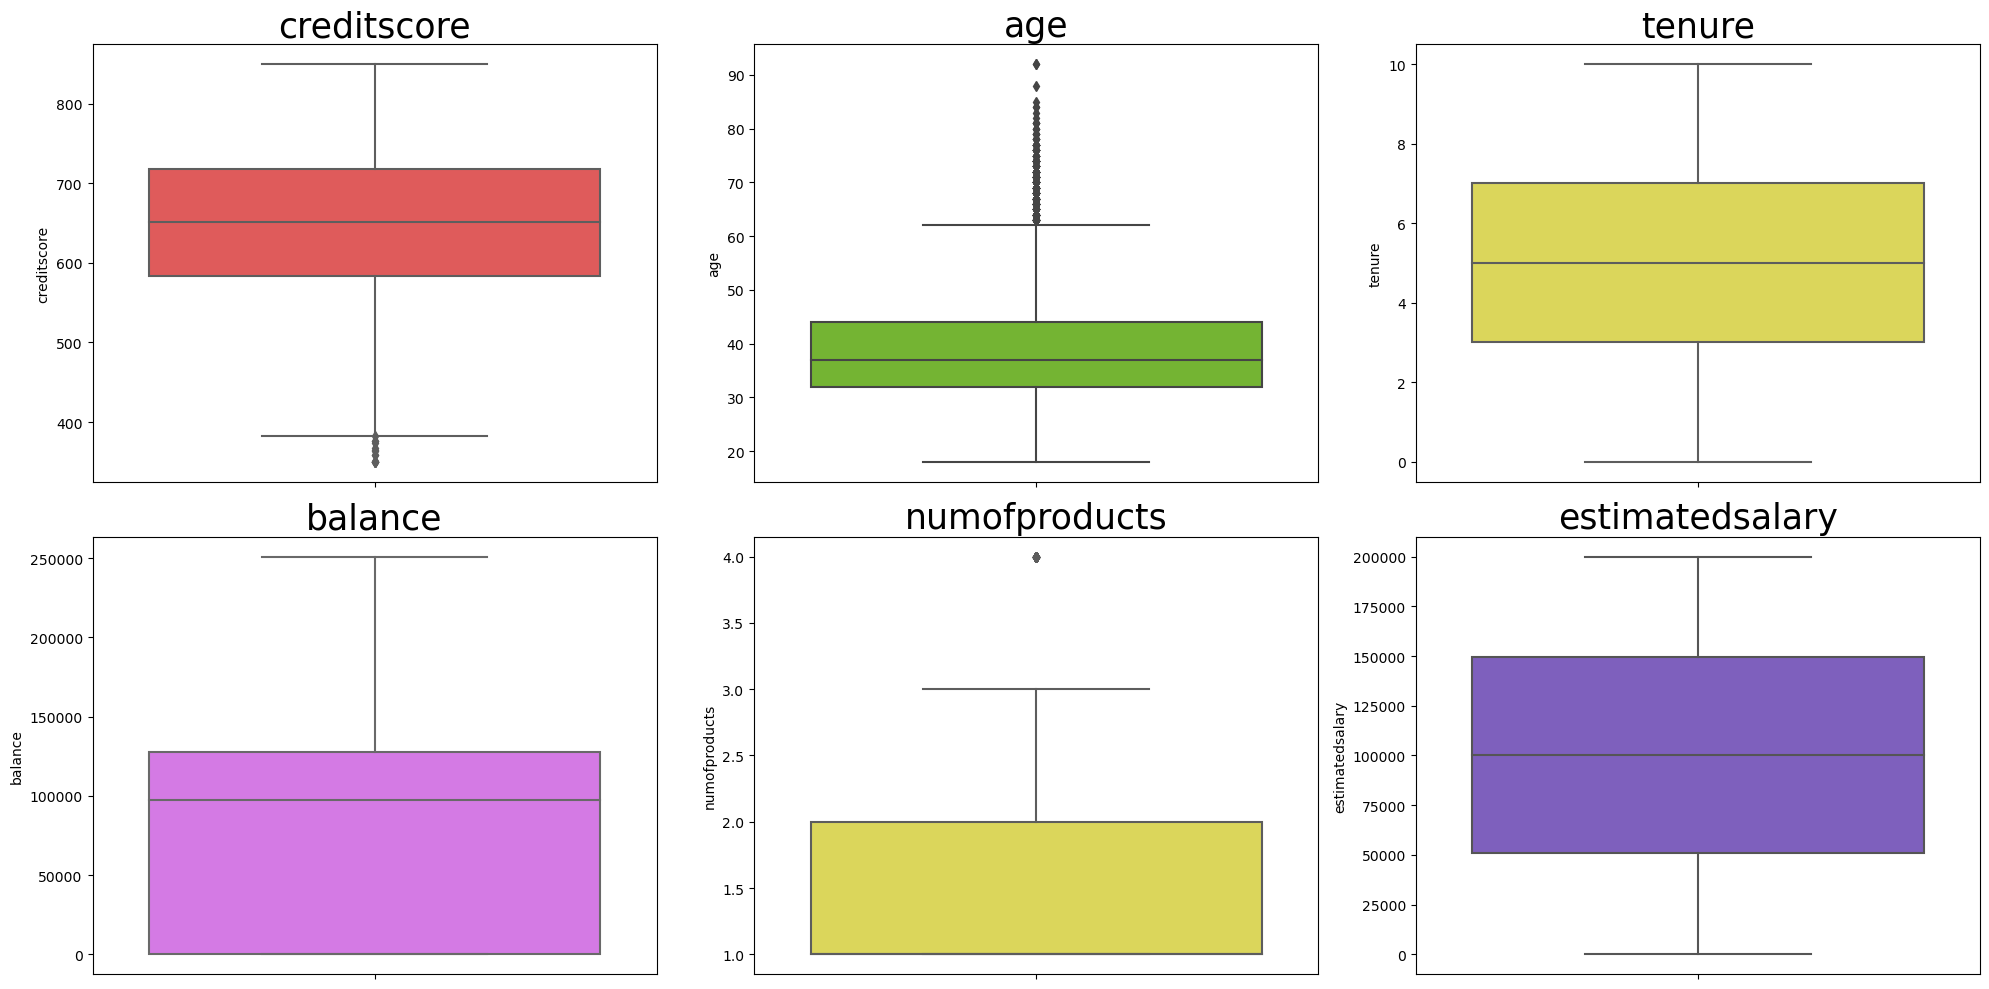

In [36]:
# menampilkan distribusi data pada kolom numerikal
fig, axes = plt.subplots(2, 3, figsize=(20, 10)) 
for i, j in zip(numeric_cols, axes.flatten()):
    ax = sns.boxplot(data=df, y= i, ax= j, order=df[i].value_counts().index, color=np.random.choice(color_plot))
    ax.set_title(f'{i}',size = 25) 
plt.tight_layout()
plt.show()

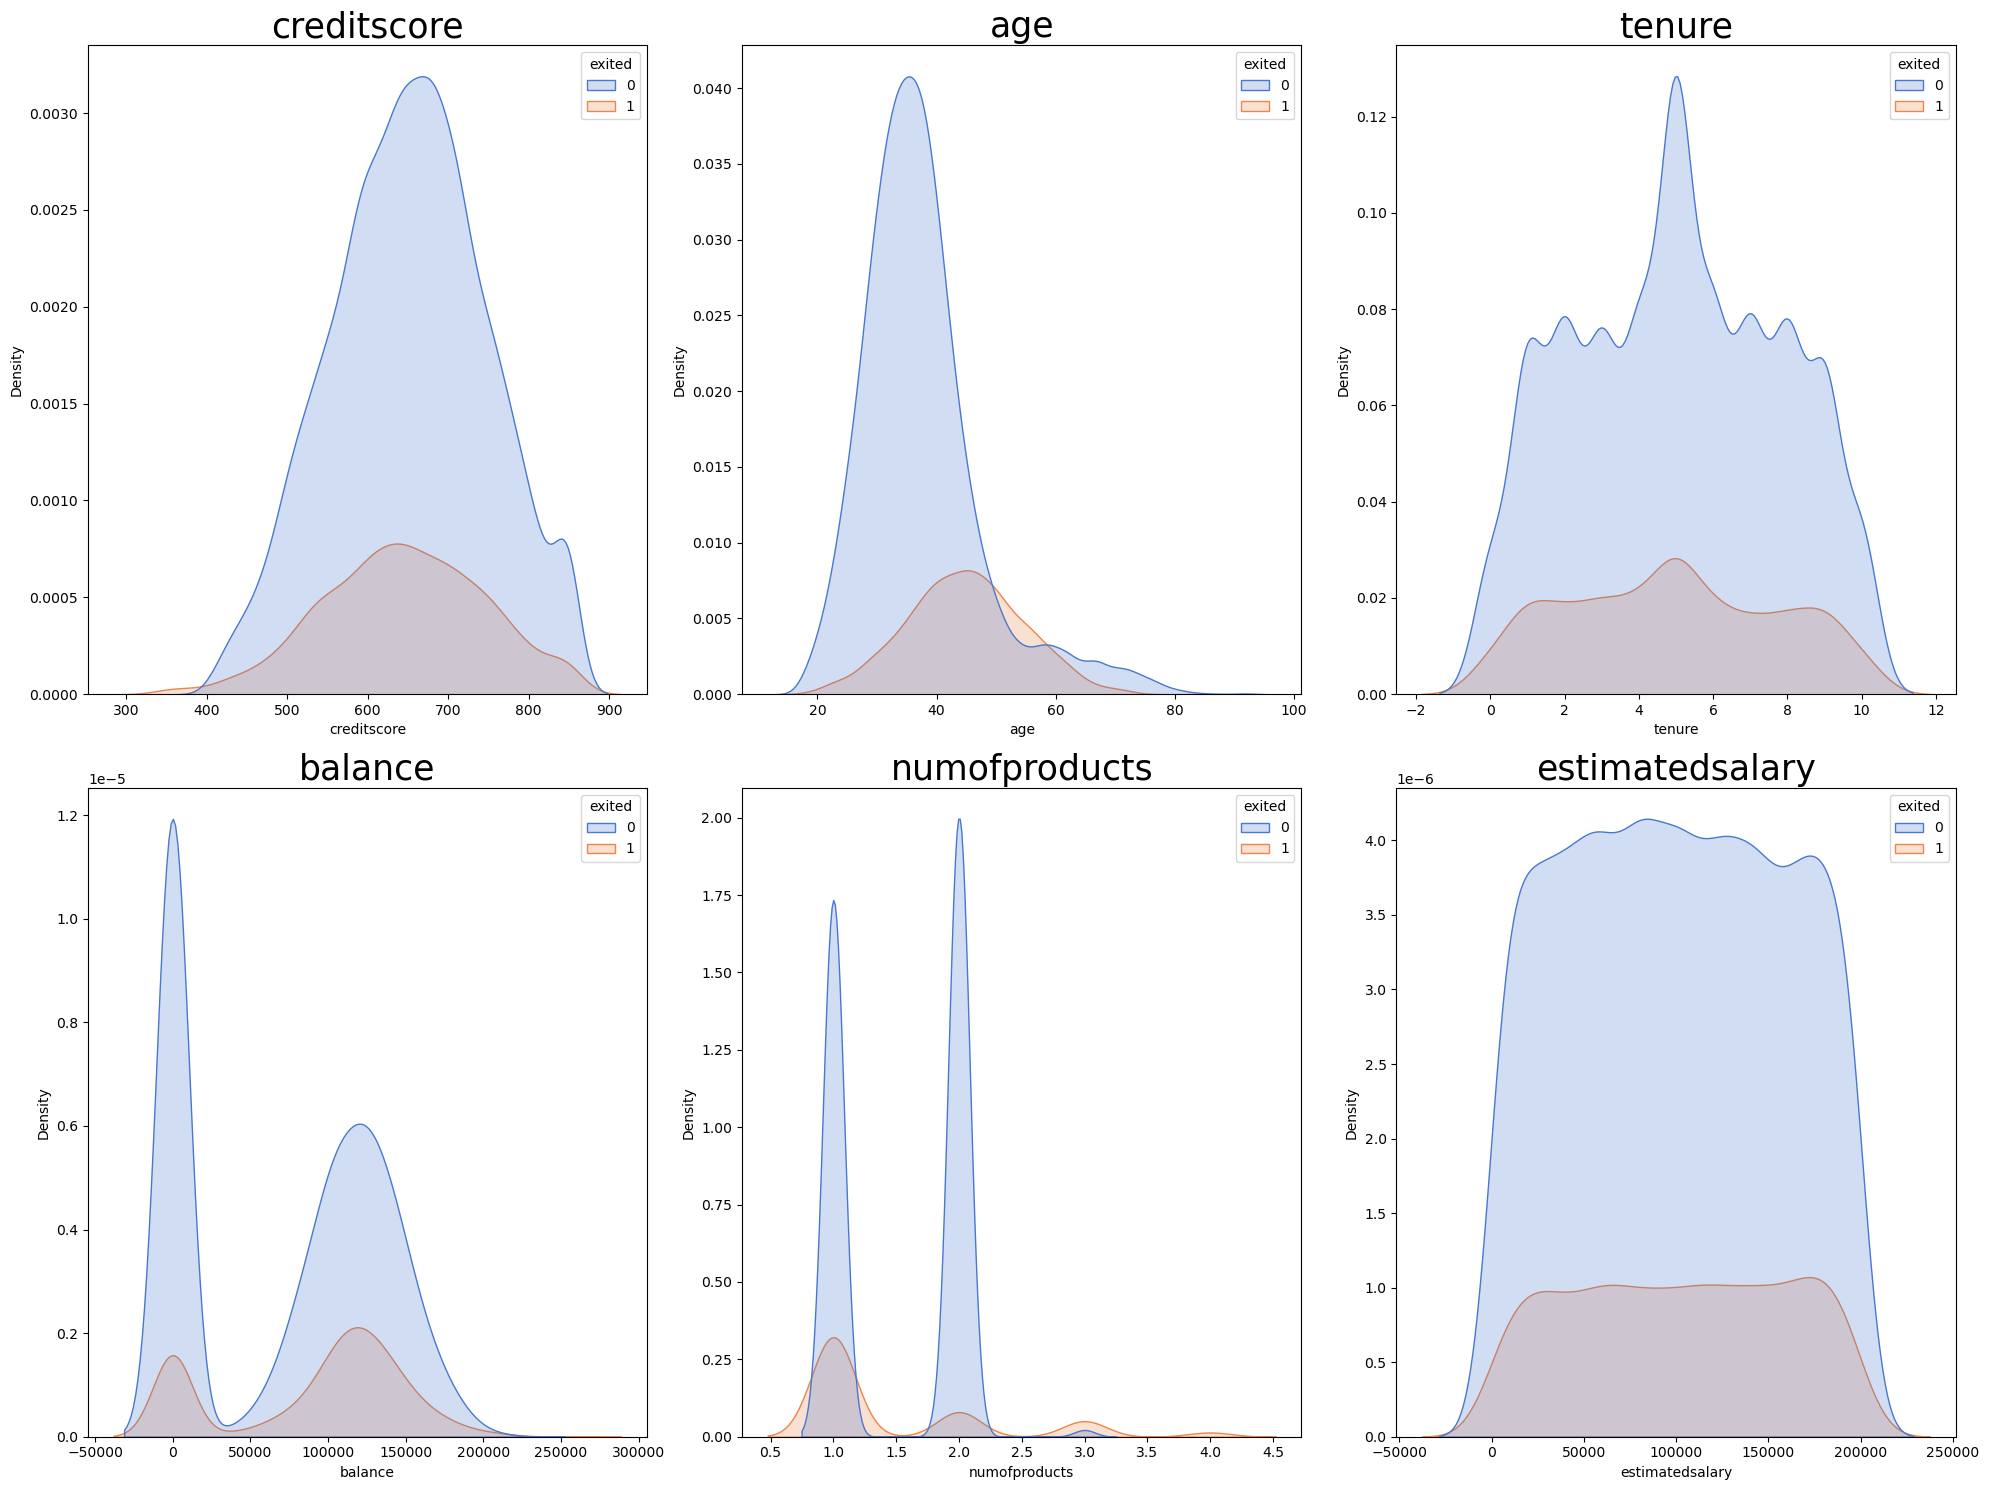

In [37]:
# menampilkan distribusi data pada kolom numerikal menggunakan kde plot
fig, axes = plt.subplots(2, 3, figsize=(20, 15)) 
for i , j in zip(numeric_cols, axes.flatten()):
    ax = sns.kdeplot(data=df, x = i, ax= j,
                      hue='exited', palette='muted', shade=True, )
    ax.set_title(f'{i}',size = 25) 
plt.tight_layout()
plt.show()



**Kesimpulan**

Kita memerhatikan untuk credit score terdapat nilai yang cukup rendah dibawah 400, setelah kita amati ternyata skor kredit yang rendah tersebut untuk kategori nasabah yang meninggalkan bank. mungkin pihak bank bisa memberikan solusi dengan mendapatkan kredit skor terendah sebanyak 400.

#### Korelasi Antar Kolom Numerik

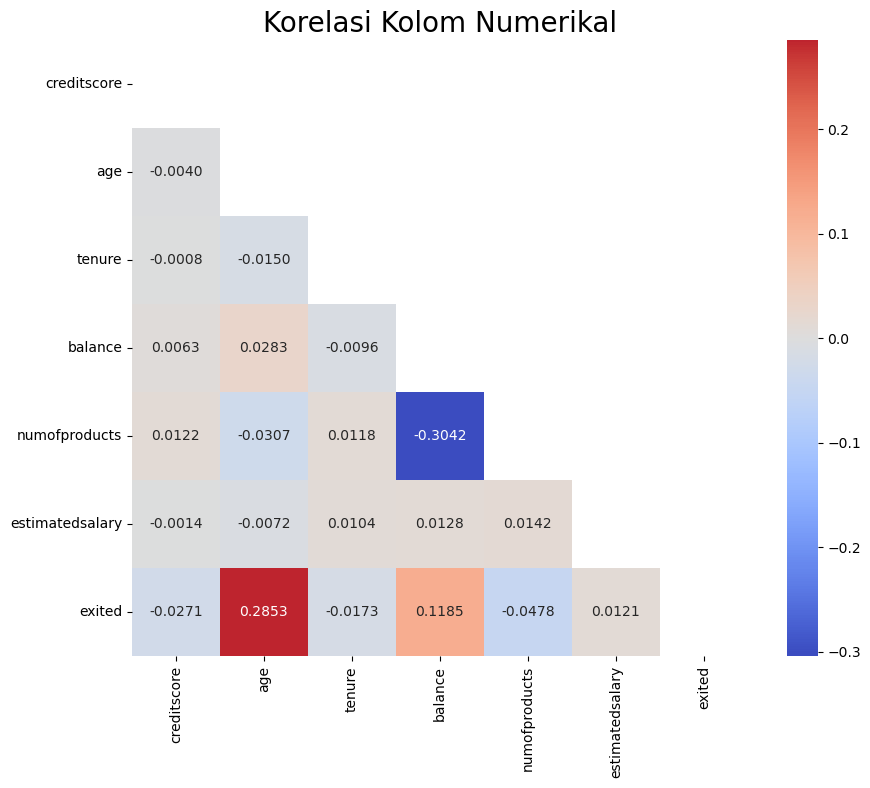

In [38]:
numeric_columns = df.describe().columns.drop(['customerid','hascrcard','isactivemember'])

# visualisasi korelasi untuk kolom numerik
plt.figure(figsize=(10,8))

matrix = np.triu(df[numeric_columns].corr())

sns.heatmap(data=df[numeric_columns].corr(), 
            annot=True, fmt='.4f', cmap='coolwarm', 
            center=0, 
            mask = matrix, 
            square='True')
plt.title('Korelasi Kolom Numerikal',size=20)
plt.show()

In [39]:
df.columns

Index(['customerid', 'creditscore', 'geography', 'gender', 'age',
       'age_grouped', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'salary_grouped'],
      dtype='object')

In [40]:
# menampilkan korelasi setiap kolom fitur terhadap kolom target(exited)
df.drop(['customerid','geography','gender','age_grouped','salary_grouped'], axis=1).corr()['exited'].sort_values(ascending=False)
# df.corr()['exited'].sort_values(ascending=False)


exited             1.000000
age                0.285323
balance            0.118533
estimatedsalary    0.012097
hascrcard         -0.007138
tenure            -0.017297
creditscore       -0.027094
numofproducts     -0.047820
isactivemember    -0.156128
Name: exited, dtype: float64

Sepertinya tidak terdapat korelasi linear yang begitu kuat antara kolom fitur terhadap nasabah yang meninggalkan bank dan tidak, semua nilai korelasinya mendekati 0, tidak satupun yang mendekati -1 ataupun 1. 

##### Tabel Data Outlier

In [41]:
# mencari nilai lower dan upper limit pada masing-masing kolom numerikal
list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []
percentage_outlier = []

for feature in numeric_cols: 
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_limit = df[feature].quantile(0.25) - 1.5*IQR
    upper_limit = df[feature].quantile(0.75) + 1.5*IQR
    
    list_lower.append(lower_limit)
    list_upper.append(upper_limit)
    number_lower.append(len(df[df[feature]<lower_limit])) # menghitung jumlah data yang diluar batas bawah
    number_inside.append(len(df[(df[feature]>=lower_limit) & (df[feature]<=upper_limit)])) # data yg berada didalam rentang kuartil
    number_upper.append(len(df[df[feature]>upper_limit])) # jumlah data yang diluar batas atas
    percentage_outlier.append(round((len(df[df[feature]<lower_limit]) + len(df[df[feature]>upper_limit])) / len(df)  *100, 2))

# membuat dataset untuk menampilkan jumlah dan persentase data outlier
outliers = pd.DataFrame({
    'columns' : numeric_cols,
    'lower_limit' : list_lower,
    'upper_limit' : list_upper,
    'count_outside_lower' : number_lower,
    'count_inside' : number_inside,
    'count_outside_upper' : number_upper,
    'percent_outlier' : percentage_outlier
})

outliers['percent_outlier'] = outliers['percent_outlier'].astype('str') +'%'
outliers

,columns,lower_limit,upper_limit,count_outside_lower,count_inside,count_outside_upper,percent_outlier
0,creditscore,383.00000,919.00000,15,9985,0,0.15%
1,age,14.00000,62.00000,0,9641,359,3.59%
2,tenure,-3.00000,13.00000,0,10000,0,0.0%
3,balance,-191466.36000,319110.60000,0,10000,0,0.0%
4,numofproducts,-0.50000,3.50000,0,9940,60,0.6%
5,estimatedsalary,-96577.09625,296967.45375,0,10000,0,0.0%


**Kesimpulan**

Kita mendapati outlier pada beberapa kolom, namun persentasenya cukup kecil dan data yang kita miliki ini merupakan informasi yang kita anggap cukup penting. Jadi kita akan membiarkan outlier tanpa menghapusnya.

## Data Pre-Processing

### Memeriksa Keseimbangan Kelas

,exited,count,percent
0,0,7963,79.63%
1,1,2037,20.37%


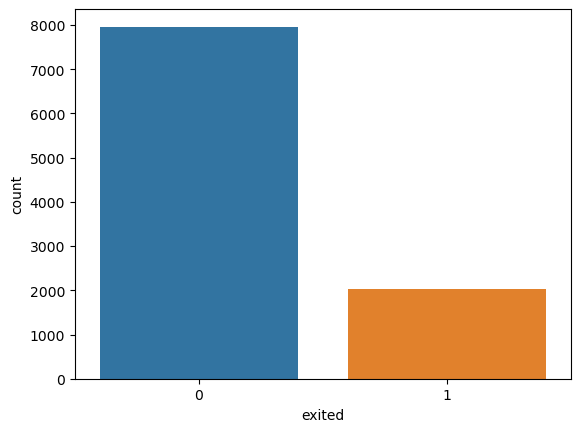

In [42]:
# menghitung proporsi target class
count_class = df.exited.value_counts().to_frame().reset_index()
count_class.columns = ['exited','count']
count_class['percent'] = (count_class['count'] / len(df) * 100).round(2).astype('str') +'%'
display(count_class),
sns.barplot(data=count_class, x='exited', y='count')
plt.show()

Kita mempunyai proporsi kelas target yang tidak seimbang. Kita akan mencoba melatih model dengan proporsi ini dan kemudian kita akan mencoba melatih model dengan kelas target yang seimbang.

Kita akan mencoba pengujian untuk mencari akurasi terbaik dengan ukuran train size berapa persen (%).

In [43]:
# menentukan fitur dan target sementara untuk pengujian test_size
features = df.drop('exited', axis=1)
target = df.exited
# mengubah kolom kategorik dengan ohe untuk fitur sementara
features_ohe = pd.get_dummies(features, drop_first=True)

# mencari tau akurasi terbaik beradasarkan test_size dari 20% sampai 40%
for t_size in np.arange(0.2, 0.5, 0.1):
    features_train, features_valid, target_train, target_valid = train_test_split(features_ohe,
                                                                                  target,
                                                                                  test_size = t_size,
                                                                                  random_state = 45
                                                                                 )
    models = [DecisionTreeClassifier(random_state=45), 
              RandomForestClassifier(random_state=45), 
              LogisticRegression(random_state=45)]
    
    for model in models:
        model_name = model.__class__.__name__
        model.fit(features_train, target_train)
        
        pred_valid = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, pred_valid)
        print(f"test_size: {t_size:.0%}")
        print(f'{model_name} - Akurasi: {accuracy:.2f}')
        print(50*'-')

test_size: 20%
DecisionTreeClassifier - Akurasi: 0.80
--------------------------------------------------
test_size: 20%
RandomForestClassifier - Akurasi: 0.86
--------------------------------------------------
test_size: 20%
LogisticRegression - Akurasi: 0.79
--------------------------------------------------
test_size: 30%
DecisionTreeClassifier - Akurasi: 0.79
--------------------------------------------------
test_size: 30%
RandomForestClassifier - Akurasi: 0.86
--------------------------------------------------
test_size: 30%
LogisticRegression - Akurasi: 0.79
--------------------------------------------------
test_size: 40%
DecisionTreeClassifier - Akurasi: 0.79
--------------------------------------------------
test_size: 40%
RandomForestClassifier - Akurasi: 0.86
--------------------------------------------------
test_size: 40%
LogisticRegression - Akurasi: 0.79
--------------------------------------------------


Secara keseluruhan akurasi setiap algoritma dengan berbagai ukuran test_size tidak terdapat perubahan yang signifikan. Namun pada test_size 20% dimana artinya untuk train_size adalah 80%, kita mendapatkan akurasi dengan algoritma DecisionTree yang terbaik senilai 80%, untuk itu kita akan menggunakan komposisi data train sebanyak 80%.

### Membagi Data Training, Data Valid, dan Data Testing.

Kita telah memutuskan untuk membagi menggunakan data training sebanyak 80%, sisanya kita akan bagi ke data validation dan data testing berarti sebanyak 10%.

In [44]:
# membagi data training yang diambil dari dataset 
df_train, df_valid_test = train_test_split(df, train_size = .8, random_state = 45)

Dataset sudah digabungkan dengan benar. Selanjutnya kita akan membagi untuk dataset validation dan testing.

In [45]:
# membagi data df_valid_test menjadi df_valid dan df_test
df_valid, df_test = train_test_split(df_valid_test, train_size = .5, random_state = 45)

**Menghitung Proporsi Data Training, Data Validation, Data Testing**

In [46]:
# menghitung proporsi setiap dataset dalam bentuk persen
data_comp = {
    'Training' : df_train,
    'Validation' : df_valid,
    'Testing' : df_test
}

for key, value in data_comp.items():
    print(f'Komposisi Data {key} - {len(value) / len(df):.0%}')

Komposisi Data Training - 80%
Komposisi Data Validation - 10%
Komposisi Data Testing - 10%


### Membagi Data Features dan Target

Kemudian data features kita akan membuang tiga (3) kolom yang sebelumnya kita gunakan dalam tahap EDA, yaitu:
- `customerid`
- `age_grouped`
- `salary_grouped`

**Data Features**

In [47]:
# data features
# 1. features train
features_train = df_train.drop(['customerid','age_grouped','salary_grouped','exited'], axis=1)
# 2. features valid
features_valid = df_valid.drop(['customerid','age_grouped','salary_grouped','exited'], axis=1)
# 3. features testing
features_test = df_test.drop(['customerid','age_grouped','salary_grouped','exited'], axis=1)

**Data Target**

In [48]:
# data target
# 1. target train
target_train = df_train.exited
# 2. target valid
target_valid = df_valid.exited
# 3. target test
target_test = df_test.exited

**Catatan**

Dalam konteks dataset yang kita miliki terdapat 2 kolom kategorikal yaitu `geography` dan `gender` dimana merupakan variabel nomimal atau tidak terdapat urutan tertentu dalam data. Maka kolom maka `geography` dan `gender` dapat dienkoding dengan One-Hot Encoding untuk digunakan dalam model Logistic Regression, Decision Tree, dan Random Forest. 

One-Hot Encoding adalah pendekatan yang umum digunakan untuk mengatasi data kategorikal yang tidak memiliki hubungan ordinal yang kuat, dan ini memungkinkan model untuk menangani kategori dengan cara yang sesuai.

### Features Processing

In [49]:
# Definisi transformasi untuk setiap grup fitur
categorical_features = ['gender', 'geography']
numeric_features = ['creditscore','age','tenure','balance','numofproducts','estimatedsalary']

In [50]:
# transoformasi kolom numerik menggunakan robust scaler
numeric_transformer = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])
# transformasi kolom kategorik menggunakan ohe
categoric_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder())
])

# Menggabungkan transformasi dalam ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categoric_transformer, categorical_features)
])

## Training Model With Imbalance Class

In [51]:
# membuat fungsi
def algoritma_metrix_score(features, target, title, hyperparameters, f_train, t_train):
    f1score = []
    accuracy = []
    model_name = []
    precision = []
    recall = []
    auc_roc = []
    #
    models = [DecisionTreeClassifier(**hyperparameters), 
              RandomForestClassifier(**hyperparameters),
              LogisticRegression(**hyperparameters),
              KNeighborsClassifier(n_neighbors = 5),              
             ]
    #
    for algoritma in models:
        model = Pipeline([
            ('prep', preprocessor),
            ('algo', algoritma)
        ])
        #
        name = algoritma.__class__.__name__

        model.fit(f_train, t_train)
        predicted = model.predict(features)
        #
        accuracy.append(model.score(features, target))
        model_name.append(name)
        f1score.append(f1_score(target, predicted))
        precision.append(precision_score(target, predicted))
        recall.append(recall_score(target, predicted))
        auc_roc.append(roc_auc_score(target, model.predict_proba(features)[:, 1]))

    df_matrix_score = pd.DataFrame({'model_name' : model_name,
                                    'accuracy_score' : accuracy,
                                    'precision_score' : precision,
                                    'recall_score' : recall,
                                    'f1_score' : f1score,
                                    'auc_roc' : auc_roc})
    
    return df_matrix_score.style.set_caption(title)

In [52]:
# menentukan hyper-param
hyperparameters = {
    'random_state': 45,
}

In [53]:
# memanggil fungsi untuk melihat skor metriks data train dan data validation
display(algoritma_metrix_score(features_train, target_train, 'Matrix Data Train', hyperparameters,
                               features_train, target_train
                              ),
        algoritma_metrix_score(features_valid, target_valid, 'Matrix Data Validation', hyperparameters,
                               features_train, target_train
                              ))

,model_name,accuracy_score,precision_score,recall_score,f1_score,auc_roc
0,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,0.999875,1.000000,0.999382,0.999691,1.000000
2,LogisticRegression,0.792875,0.452785,0.115575,0.184146,0.753522
3,KNeighborsClassifier,0.868250,0.763060,0.505562,0.608178,0.915003


,model_name,accuracy_score,precision_score,recall_score,f1_score,auc_roc
0,DecisionTreeClassifier,0.788000,0.464789,0.502538,0.482927,0.680285
1,RandomForestClassifier,0.852000,0.709402,0.421320,0.528662,0.839188
2,LogisticRegression,0.795000,0.437500,0.142132,0.214559,0.736837
3,KNeighborsClassifier,0.838000,0.637795,0.411168,0.500000,0.784804


Sepertinya dengan ketidak seimbangan class pada data dan dengan hyper-param yang default, kita mendapat f1 score yang cukup rendah. Tidak satupun dari model kita mendapatkan nilai f1-score sebanyak 0.59. 

## Balancing Class / Memperbaiki Keseimbangan Kelas Target

Ada beberapa pendekatan yang dilakukan untuk menangani imbalance class, :
1. Class Weight Adjustment (Hyper-Param 'class_weight')
2. Up Sampling

**1. Class Weight Adjustment**

Hal yang pertama kita lakukan dengan penyeimbangan kelas dengan mengatur hyper-param `class_weight`.

In [54]:
# menentukan hyper-param
hyperparameters = {
    'random_state': 45,
    'class_weight' : 'balanced'
}

In [55]:
# memanggil fungsi untuk melihat skor metriks data train dan data validation
display(algoritma_metrix_score(features_train, target_train, 'Matrix Data Train', hyperparameters,
                               features_train, target_train
                              ),
        algoritma_metrix_score(features_valid, target_valid, 'Matrix Data Validation', hyperparameters,
                               features_train, target_train
                              ))

,model_name,accuracy_score,precision_score,recall_score,f1_score,auc_roc
0,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
2,LogisticRegression,0.713000,0.381882,0.677379,0.488414,0.756936
3,KNeighborsClassifier,0.868250,0.763060,0.505562,0.608178,0.915003


,model_name,accuracy_score,precision_score,recall_score,f1_score,auc_roc
0,DecisionTreeClassifier,0.790000,0.462857,0.411168,0.435484,0.647053
1,RandomForestClassifier,0.853000,0.727273,0.406091,0.521173,0.840860
2,LogisticRegression,0.709000,0.370166,0.680203,0.479428,0.738487
3,KNeighborsClassifier,0.838000,0.637795,0.411168,0.500000,0.784804


Dengan mengatur hyper-param `class_weight` kita mendapatkan peningkatan f1_score namun akurasinya berkurang pada algoritma `LogisticRegression`untuk data validation. Sedangkan untuk algoritma `DecisionTree` dan `RandomForest` terdapat penurunan nilai f1_score pada data validationnya.

**2. Up Sampling**

Upsampling bertujuan untuk meningkatkan jumlah sampel pada kelas yang kurang, sehingga kelas-kelas dalam data train menjadi lebih seimbang. Ini dilakukan dengan menambahkan lebih banyak sampel dari kelas minoritas.

In [56]:
hyperparameters = {
    'random_state': 45,
}

In [57]:
# fungsi untuk upsampling data training
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    #
    target_zeros = target[target == 0]
    target_ones = target[target == 1] 
    
    # Mengulang features dan target dari kelas minoritas
    features_up = pd.concat([features_zeros] + [features_ones] * repeat)
    target_up = pd.concat([target_zeros] + [target_ones] * repeat)
    # Mengacak data upsampled
    features_upsampled, target_upsampled = shuffle(features_up, target_up, random_state = 45)
    return features_upsampled, target_upsampled



In [58]:
# mendapatkan features dan target yang telah di upsampling
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [59]:
# ukuran data setelah upsampled - features disebelah kiri dan ukuran target disebelah kanan 
features_upsampled.shape, target_upsampled.shape

((12854, 10), (12854,))

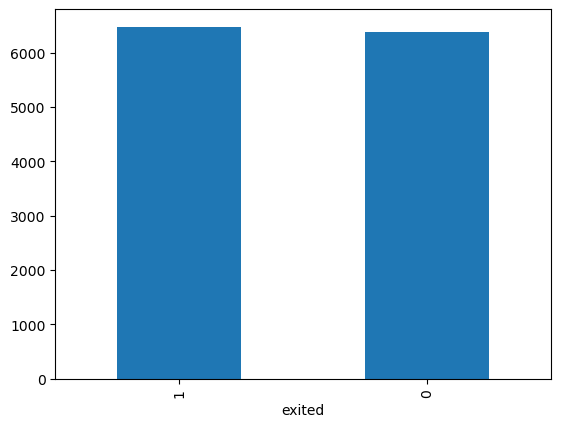

In [60]:
# membuat visualisasi ukuran kelas target
target_upsampled.value_counts().plot(kind='bar')
plt.show()

Selanjutnya kita coba melatih model dengan data kelas yang sudah balance.

In [61]:
# memanggil fungsi untuk melihat skor metriks data train dan data validation
display(algoritma_metrix_score(features_train, target_train, 'Matrix Data Train', hyperparameters,
                               features_upsampled, target_upsampled
                              ),
        algoritma_metrix_score(features_valid, target_valid, 'Matrix Data Validation', hyperparameters,
                               features_upsampled, target_upsampled
                              ))

,model_name,accuracy_score,precision_score,recall_score,f1_score,auc_roc
0,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
2,LogisticRegression,0.708625,0.377869,0.681706,0.486224,0.756947
3,KNeighborsClassifier,0.819500,0.528413,1.000000,0.691453,0.963944


,model_name,accuracy_score,precision_score,recall_score,f1_score,auc_roc
0,DecisionTreeClassifier,0.787000,0.454545,0.406091,0.428954,0.643270
1,RandomForestClassifier,0.841000,0.617284,0.507614,0.557103,0.831833
2,LogisticRegression,0.708000,0.369863,0.685279,0.480427,0.738500
3,KNeighborsClassifier,0.713000,0.383420,0.751269,0.507719,0.775493


## Optimized Model Dengan Tuning Beberapa Parameter

### Optimized Random Forest Classifier

**Parameter `n_estimators`**

Pertama kita akan mencoba cari hasil f1-score terbaik dengan menggunakan n_estimators.

In [62]:
# kumpulan list untuk menamping data yang dilooping
best_estimator = []
accuracy = []
scorer_f1 = []
precision = []
recall = []
auc_roc = []

# looping untuk n_estimators
for est in range(1, 30, 1):
    RFClass = RandomForestClassifier(random_state = 45, n_estimators = est)
    
    model = Pipeline([
        ('prep', preprocessor),
        ('algo', RFClass)
    ])
    
    model.fit(features_upsampled, target_upsampled)
    
    predict_valid = model.predict(features_valid)
    accuracy_scorer = accuracy_score(target_valid, predict_valid)
    #
    accuracy.append(accuracy_scorer)  
    scorer_f1.append(f1_score(target_valid, predict_valid))
    precision.append(precision_score(target_valid, predict_valid))
    recall.append(recall_score(target_valid, predict_valid))
    auc_roc.append(roc_auc_score(target_valid, predict_valid))
    best_estimator.append(est)

In [63]:
# membuat dataset berdasarkan data hasil looping berdasarkan n_estimators
df_rf_score = pd.DataFrame({'n_estimators' : best_estimator,
                                'accuracy_score' : accuracy,
                                'precision_score' : precision,
                                'recall_score' : recall,
                                'f1_score' : scorer_f1,
                                'auc_roc' : auc_roc})
# menampilkannya
df_rf_score.sort_values('f1_score', ascending=False).head()

,n_estimators,accuracy_score,precision_score,recall_score,f1_score,auc_roc
28,29,0.838,0.607362,0.502538,0.550000,0.711418
10,11,0.830,0.575419,0.522843,0.547872,0.714099
27,28,0.840,0.619355,0.487310,0.545455,0.706918
25,26,0.838,0.610063,0.492386,0.544944,0.707588
24,25,0.833,0.589286,0.502538,0.542466,0.708305


Pencarian berdasarkan n_estimators kita mendapat nilai f1_score tertinggi di angka 0.56 pada n_estimators = 25. Kita akan menggunakan angka ini dan lanjut pencarian untuk max_depth.

**Parameter `max_depth`**

In [64]:
# kumpulan list untuk menamping data yang dilooping
depth_est = []
accuracy = []
scorer_f1 = []
precision = []
recall = []
auc_roc = []

# looping untuk kedalaman depth dari 1 sampai 30
for depth in range(1, 30):
    RFClass = RandomForestClassifier(random_state = 45, n_estimators = 25, max_depth = depth) 
    
    model = Pipeline([
        ('prep', preprocessor),
        ('algo', RFClass)
    ])
    
    model.fit(features_upsampled, target_upsampled)
    
    predict_valid = model.predict(features_valid)
    accuracy_scorer = accuracy_score(target_valid, predict_valid)
    #
    accuracy.append(accuracy_scorer)    
    scorer_f1.append(f1_score(target_valid, predict_valid))
    precision.append(precision_score(target_valid, predict_valid))
    recall.append(recall_score(target_valid, predict_valid))
    auc_roc.append(roc_auc_score(target_valid, predict_valid))
    depth_est.append(depth)

In [65]:
# membuat dataset hasil datanya
df_rf_score = pd.DataFrame({'depth' : depth_est,
                            'accuracy_score' : accuracy,
                            'precision_score' : precision,
                            'recall_score' : recall,
                            'f1_score' : scorer_f1,
                            'auc_roc' : auc_roc})

# menampilkan 5 data teratas
df_rf_score.sort_values('f1_score', ascending=False).head()

,depth,accuracy_score,precision_score,recall_score,f1_score,auc_roc
20,21,0.852,0.644970,0.553299,0.595628,0.739290
5,6,0.798,0.491694,0.751269,0.594378,0.780367
16,17,0.842,0.604278,0.573604,0.588542,0.740725
21,22,0.846,0.621469,0.558376,0.588235,0.737469
9,10,0.806,0.505495,0.700508,0.587234,0.766194


Dapat kita lihat bahwa f1_score tertinggi untuk ukuran max_depth = 6 dimana nilainya 0.594 hanya berbeda sedikit dengan max_depth = 20. Akan tetapi untuk akurasi, max_depth = 20 mendapatkan nilai tertinggi yaitu 0.85. Karena project ini kita berfokus pada nilai f1_score, maka kita akan menggunakan nilai max_depth = 6.

**Parameter `min_samples_split` dan `max_leaf_nodes`**

In [66]:
# kumpulan list untuk menamping data yang dilooping
sample_split = []
leaf_node_ = []
accuracy = []
scorer_f1 = []
precision = []
recall = []
auc_roc = []

# looping untuk min_samples_split dan max_leaf_nodes
for split in np.arange(2, 10):
    for leaf_node in range(2, 30):
        RFClass = RandomForestClassifier(random_state = 45, n_estimators = 25, max_depth = 6, 
                                         min_samples_split = split, max_leaf_nodes = leaf_node)

        model = Pipeline([
            ('prep', preprocessor),
            ('algo', RFClass)
        ])

        model.fit(features_upsampled, target_upsampled)

        predict_valid = model.predict(features_valid)
        accuracy_scorer = accuracy_score(target_valid, predict_valid)
        #
        accuracy.append(accuracy_scorer)
        scorer_f1.append(f1_score(target_valid, predict_valid))
        precision.append(precision_score(target_valid, predict_valid))
        recall.append(recall_score(target_valid, predict_valid))
        auc_roc.append(roc_auc_score(target_valid, predict_valid))        
        leaf_node_.append(leaf_node)
        sample_split.append(split)
        

In [67]:
# membuat dataset hasil datanya
df_rf_score = pd.DataFrame({'max_leaf_nodes' : leaf_node_,
                            'min_samples_split' : sample_split,
                                'accuracy_score' : accuracy,
                                'precision_score' : precision,
                                'recall_score' : recall,
                                'f1_score' : scorer_f1,
                                'auc_roc' : auc_roc})

# menampilkan 5 data teratas
df_rf_score.sort_values('f1_score', ascending=False).head()

,max_leaf_nodes,min_samples_split,accuracy_score,precision_score,recall_score,f1_score,auc_roc
139,29,6,0.795,0.486755,0.746193,0.589178,0.776583
55,29,3,0.795,0.486755,0.746193,0.589178,0.776583
27,29,2,0.795,0.486755,0.746193,0.589178,0.776583
83,29,4,0.795,0.486755,0.746193,0.589178,0.776583
167,29,7,0.795,0.486755,0.746193,0.589178,0.776583


Sepertinya pencarian untuk max_leaf_nodes dan min_samples_split kita tidak mendapatkan hasil yang baik, dimana nilai f1_score tertinggi hanya 0.589.

**Kesimpulan**

Setelah melakukan tuning hyper-parameter, kita mendapatkan nilai f1_score tertinggi sebanyak 0.59, dimana nilai ini sudah termasuk nilai mininum untuk standar project ini. Dengan f1_score 0.59 kita mendapat hyper-parameternya yaitu:
- max_depth = 6.
- n_estimators = 25.

Selanjutnya kita akan menggunakan hyper-parameter ini untuk menguji pada data testing.

### Optimizes K-Nearest Neighbor

In [68]:
# definisi model
knn = KNeighborsClassifier()

In [69]:
model = Pipeline([
    ('prep', preprocessor),
    ('algo', knn)
])

# Membuat objek GridSearchCV dengan f1_score sebagai metrik evaluasi
scoring = make_scorer(f1_score)

param_grid = {
    'algo__n_neighbors': [3, 5, 7, 9],  # Coba beberapa nilai untuk n_neighbors
    'algo__weights': ['uniform', 'distance'],  # Coba jenis bobot yang berbeda
    'algo__p': [1, 2]  # Coba jarak Manhattan (1) dan Euclidean (2)
}

# Membuat objek GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5)

# Melakukan pencarian parameter
grid_search.fit(features_upsampled, target_upsampled)

# Menampilkan parameter terbaik dan skor terbaik
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
print("Parameter Terbaik:", best_params)

Parameter Terbaik: {'algo__n_neighbors': 9, 'algo__p': 1, 'algo__weights': 'distance'}


In [70]:
# melatih model dengan parameter terbaik
best_model.fit(features_upsampled, target_upsampled)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('RobustScaler',
                                                                   RobustScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'numofproducts',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'geography'])])),
                ('algo',
                 KNeighborsClassifier(n_neighbors=9, p=1, weights='distance'))])

In [71]:
predict_valid = best_model.predict(features_valid)
# menampilkan nilai f1_score
f1_score(target_valid, predict_valid)

0.5510597302504817

In [72]:
print(classification_report(target_valid, predict_valid))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       803
           1       0.44      0.73      0.55       197

    accuracy                           0.77      1000
   macro avg       0.68      0.75      0.70      1000
weighted avg       0.83      0.77      0.79      1000



Sepertinya kita mendapatkan nilai f1_score hanya 0.55 dan akurasi nya juga tidak begitu bagus dibandingkan dengan algoritma Random Forest.

## Final Test Untuk Data Test

Sebelumnya kita telah mencoba 4 algoritma untuk melatih model kita. Akan tetapi hasil f1_score yang maksimal kita dapatkan dengan algoritma `RandomForestClassifier` dimana nilainya 0.59. Untuk itu kita akan melakukan uji coba pada data testing menggunakan algoritma Random Forest tersebut. 

In [73]:
# definisi model
RFClass = RandomForestClassifier(random_state = 45, n_estimators = 25, max_depth = 6)
model = Pipeline([
    ('prep', preprocessor),
    ('algo', RFClass)
])

model.fit(features_upsampled, target_upsampled)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('RobustScaler',
                                                                   RobustScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'numofproducts',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'geography'])])),
                ('algo',
                 RandomForestClassifier(max_depth=6, n_estimators=25,
                                        random_state=45))])

In [74]:
predict_test = model.predict(features_test)
# accuracy_scorer = accuracy_score(target_test, predict_valid)

In [75]:
# menampilkan f1_score
f1_score(target_test, predict_test)

0.6088560885608856

In [76]:
# roc_auc_score
roc_auc_score(target_test, predict_test)

0.7720072257347321

In [77]:
# akurasi skor
accuracy_score(target_test, predict_test)

0.788

## Kesimpulan Umum

Kita mempunyai dataset dengan 10.000 baris dan 14 kolom dan terdapat nilai yang hilang pada kolom `tenure` sebanyak 9%. Kita mengisi nilai yang hilang dengan menggunakan median berdasarkan kelompok usia, kelompok gaji, dan negara asal nasabah. 

Pada tahap Analisis Data Eksploratif (EDA) ada beberapa hal yang mungkin baik dilakukan pihak bank kepada nasabah, hal tersebut mungkin bisa mengurangi tingkat kehilangan nasabah dari pihak bank. 

Kemudian pada tahapan melatih model, kita membuang beberapa kolom fitur yang tidak berguna dan membiarkan data outlier tanpa menghapusnya, kemudian kita menggunakan teknik RobustScaler() untuk penskalaan fitur karena teknik ini dianggap lebih efisien untuk data yang berisi outlier. Berdasarkan ke-4 algoritma yang kita uji, kita mendapatkan hasil f1_score terbaik dengan menggunakan model `RandomForestClassifier`, dimana f1_score untuk data validationnya sebanyak `0.59` dan untuk data test-nya sebanyak `0.608`. Sedangkan untuk akurasi dengan menggunakan algoritma ini kita hanya mendapatkan nilai sebesar `0.79` untuk data validation dan `0.78` untuk data test.